# Assignment — Link prediction

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import requests
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

### Task 1. Dataset for link prediction (0 points)

Consider link prediction on the [e-mails network](http://snap.stanford.edu/data/email-Eu-core-temporal.html) where nodes are members of a research institution and edges are e-mails given with timestamps. The goal is to predict occurrence of edges in the test time period using information from the train time period only.

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/email-Eu-core-temporal.txt'
open('email-Eu-core-temporal.txt', 'wb').write(requests.get(url).content);


In [3]:
email_df = pd.read_csv(
    'email-Eu-core-temporal.txt', 
    delimiter=' ', 
    names=['sender', 'receiver', 'timestamp']
)
email_df.head()

,sender,receiver,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


Next, consider the following preprocessing procedure:
1. Select edges by given train and test time periods, for example, [0, 1000) is train and [1000, 2000) is test
2. Build a _core_ — a connected network where every edge occurs at least $k_\text{train}$ times in the train time period or at least $k_\text{test}$ times in the test time period. Let the core be undirected, so occurrences edges (1, 0) and (0, 1) are computed together.
3. From the core, select a train set of edges $E_\text{train}$ that occur for the first time in the train period. All others are included to $E_\text{test}$.
3. Exclude test edges that contain nodes that do not occur in train edges.

Write a function `train_test_edges` that takes a pd.DataFrame `email_df` with e-mail network, a tuple with the train time period borders `train_period`, say, (0, 1000), a similar tuple `test_period`, the number of edges occurrences `ktrain` and `ktest`. The function returns two lists with tuples — train and test edges. Every edge is returned of the form where the first node is less than the second, for example [(1, 2), (2, 3)] is ok, but [(2, 1), (3, 2)] is wrong.

In [4]:
def train_test_edges(email_df, train_period, test_period, ktrain, ktest):
    
    email_temp = email_df.copy()
    email_temp = email_temp[
        (train_period[0] <= email_temp.timestamp) 
        & (email_temp.timestamp < test_period[1])
    ]
    email_temp['from'] = email_temp[['sender', 'receiver']].min(axis=1)
    email_temp['to'] = email_temp[['sender', 'receiver']].max(axis=1)
    email_temp = email_temp.drop(['sender', 'receiver'], axis=1)
    email_temp = email_temp.set_index(['from', 'to'])

    email_train = email_temp[email_temp.timestamp < train_period[1]]
    email_train = email_train.groupby(['from', 'to']).count()
    train_core = email_train[email_train.timestamp >= ktrain].index.tolist()

    email_test = email_temp[test_period[0] <= email_temp.timestamp]
    email_test = email_test.groupby(['from', 'to']).count()
    test_core = email_test[email_test.timestamp >= ktest].index.tolist()
    
    core = list(set(train_core + test_core))

    # YOUR CODE HERE
    first_edges = email_temp.loc[core].groupby(['from', 'to']).min()
    train_edges = first_edges[first_edges.timestamp < test_period[0]].index.tolist()
    _test_edges = first_edges[first_edges.timestamp >= test_period[0]].index.tolist()
    train_nodes = np.unique(train_edges)
    test_edges = [(u, v) for (u, v) in _test_edges if u in train_nodes and v in train_nodes]
    return train_edges, test_edges

In [5]:
train_edges, test_edges = train_test_edges(email_df, (1e7, 2e7), (2e7, 2.5e7), 3, 3)
_train_edges, _test_edges = np.array(train_edges), np.array(test_edges)
assert np.all(_train_edges[:, 0] < _train_edges[:, 1])
assert np.all(_test_edges[:, 0] < _test_edges[:, 1])
assert len(set(train_edges).intersection(test_edges)) == 0
assert _train_edges.shape == (4147, 2)
assert _test_edges.shape == (391, 2)

### Task 2. Negative sampling (0 points)

Usually, graphs are sparse, so there is a high imbalance between positive (edge exists) and negative classes.
To eliminate this problem, we can use the undersampling technique. 

The `negative_sampling` function samples the unexisted edges from the graph.

In [6]:
def negative_sampling(train_edges, test_edges):
    # YOUR CODE HERE
    negative_edges = set()
    all_edges = train_edges + test_edges
    nodes = np.unique(all_edges)
    len_test_edges = len(test_edges)
    while len(negative_edges) < len_test_edges:
        u, v = np.random.choice(nodes, size=2)
        u, v = min(u, v), max(u, v)
        if (u, v) not in all_edges:
            negative_edges.add((u, v))
    return list(negative_edges)

In [7]:
negatives = negative_sampling(train_edges, test_edges)
assert len(negatives) == len(test_edges)
assert len(set(negatives) & set(test_edges)) == 0
assert len(set(negatives) & set(train_edges)) == 0

Build test pairs of nodes that contains test and negative edges.

In [8]:
test_pairs = np.random.permutation(negatives + test_edges)
y_true = [int((u, v) in test_edges) for (u, v) in test_pairs]
y_true[:10]

[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]

### Task 3. Similarity based algorithm (0 points)

The similarity based algorithm:
1. Compute similarity matrix for test pairs using a graph on train edges
2. Order that pairs in descending of similarity
3. Select some threshold and predict links for all pairs above the threshold

Write a function `sim_link_prediction` that takes a list with train edges, test pairs and true lables. The function predicts links and returns a tuple with metrics: 
* two np.arrays: FPR (false positive rate) and TPR (true positive rate) in descending of thresholds obtained by Jaccard coefficient, `nx.jaccard_coefficient`
* the same, by Adamic/Adar index, `nx.adamic_adar_index`
* the same, by resource allocation index, `nx.resource_allocation_index`

_Hint: use `sklearn.metrics.roc_curve`._

In [9]:
def sim_link_prediction(train_edges, test_pairs, y_true):
    
    G = nx.Graph()
    G.add_edges_from(train_edges)
    
    # YOUR CODE HERE
    res = []
    for metric in (nx.jaccard_coefficient, nx.adamic_adar_index, nx.resource_allocation_index):
        sim = [p for u, v, p in metric(G, test_pairs)]
        fpr, tpr, _ = roc_curve(y_true, sim)
        res.append((fpr, tpr))
    return res

In [10]:
jac, adam, res = sim_link_prediction(
    train_edges, 
    [[537, 120], [267, 630], [37, 730], [251, 887], [773, 97], [327, 506], [280, 687]],
    [0, 1, 1, 0, 0, 1, 0]
)
assert jac[0].shape == jac[1].shape
assert adam[0].shape == adam[1].shape
assert res[0].shape == res[1].shape
assert round(auc(jac[0], jac[1]), 4) == 1
assert round(auc(adam[0], adam[1]), 4) == 0.8333
assert round(auc(res[0], res[1]), 4) == 0.9167

Let us look at ROC AUC curve to compare similaritites.

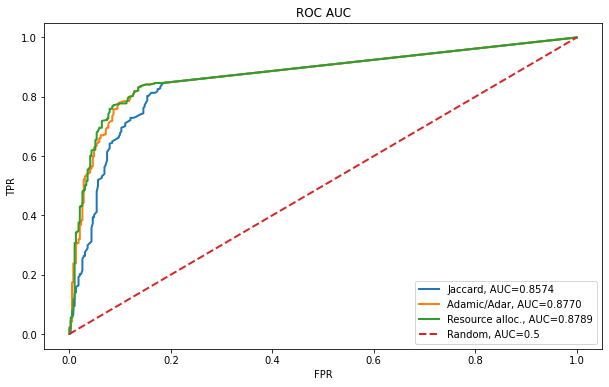

In [11]:
jac, adam, res = sim_link_prediction(train_edges, test_pairs, y_true)
plt.figure(figsize=(10, 6))
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic/Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 4. Reconstruction adjacency matrix using SVD (3 points)

Similarly to the node classification task, node embeddings could be helpful in the link prediction problem. A simple way to obtain similarity score for link prediction is to reconstruct adjacency matrix using dot product of truncated SVD node embeddings $$\tilde A_{ij} = \langle e_i, e_j \rangle$$

In [12]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_edges) + 1))
G.add_edges_from(train_edges)
A = nx.to_numpy_array(G)
model = TruncatedSVD(n_components=4, random_state=0)
emb = model.fit_transform(A)
emb.round(4)

array([[ 0.8326, -0.9149, -0.5145,  2.3371],
       [ 0.049 ,  0.0031, -0.0374, -0.0332],
       [ 2.0368,  0.8498,  0.2494,  0.7608],
       ...,
       [ 0.0062, -0.0032, -0.0087,  0.0039],
       [ 0.137 , -0.0427, -0.1047, -0.0818],
       [ 0.471 , -0.4594, -0.4649,  1.4184]])

Write a function `dot_product_scores` that takes node embeddings, test pairs, returns reconstructed scores for test pairs.

In [13]:
def dot_product_scores(emb, test_pairs):
    # YOUR CODE HERE
    return (emb[test_pairs[:, 0]] * emb[test_pairs[:, 1]]).sum(axis=1)

In [14]:
scores = dot_product_scores(emb, test_pairs)
assert scores.shape == (782, )
fpr, tpr, _ = roc_curve(y_true, scores)
assert auc(fpr, tpr) > 0.8

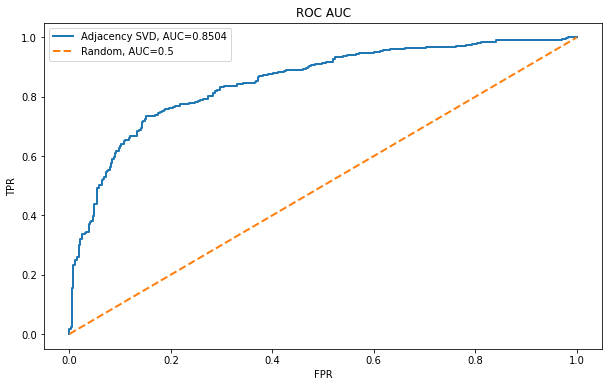

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, 
         label='{}, AUC={:.4f}'.format('Adjacency SVD', auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 5. Edge emdedding (3 points)

In this task we will solve the link prediction as classification task on edge embeddings. Let us compare several techniques of edge embedding calculation from the [paper](https://peerj.com/articles/cs-172/#table-2). We will compare the different vector aggregations as features for `sklearn.linear_model.LogisticRegression` for classification task.

In [16]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_edges) + 1))
G.add_edges_from(train_edges)
A = nx.to_numpy_array(G)
model = TruncatedSVD(n_components=4, n_iter=100)
emb = model.fit_transform(A)
emb.round(4)

array([[ 0.8326, -0.9151, -0.5147,  2.339 ],
       [ 0.049 ,  0.0031, -0.0374, -0.0319],
       [ 2.0368,  0.8496,  0.2487,  0.7585],
       ...,
       [ 0.0062, -0.0032, -0.0086,  0.0043],
       [ 0.137 , -0.0427, -0.1049, -0.0812],
       [ 0.471 , -0.4592, -0.4643,  1.4151]])

All following functions should return np.array with embeddings of edges from edges param. Average operator is simple elementwise average of node embeddings

In [17]:
def average_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return np.array([(embeddings[u] + embeddings[v]) / 2 for u, v in edges])

In [18]:
assert np.allclose(
    average_operator(G, emb, np.array([[42,70]])).round(2),
    [[ 0.55, -0.14, -0.26, -0.13]]
)

Hadamard product is an elementwise product of node embeddings

In [19]:
def hadamard_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return np.array([embeddings[u] * embeddings[v] for u, v in edges])

In [20]:
assert np.allclose(
    hadamard_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.2 , 0.02, 0.06, 0.02]]
)

Weighted L1 is a absolute of elementwise difference between node embeddings

In [21]:
def weighted_l1_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return np.array([np.abs(embeddings[u] - embeddings[v]) for u, v in edges])

In [22]:
assert np.allclose(
    weighted_l1_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.64, 0.07, 0.16, 0.11]]
)

Weighted L2 is a square of elementwise difference between node embeddings

In [23]:
def weighted_l2_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return np.array([(embeddings[u] - embeddings[v]) ** 2 for u, v in edges])

In [24]:
assert np.allclose(
    weighted_l2_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.41, 0.01, 0.03, 0.01]]
)

Neighbor weighted L1 is a absolute of elementwise difference between mean embeddings of node neigbors with itself

In [25]:
def neighbor_weighted_l1_operator(G, embeddings, edges):
    # YOUR CODE HERE
    res = []
    for u, v in edges:
        u_neigh = (embeddings[[u] + list(G.neighbors(u))]).mean(axis=0)
        v_neigh = (embeddings[[v] + list(G.neighbors(v))]).mean(axis=0)
        res.append(np.abs(u_neigh - v_neigh))
    return np.array(res)

In [26]:
assert np.allclose(
    neighbor_weighted_l1_operator(G, emb, np.array([[42,70]])).round(2),
    [[2.17, 0.18, 0.34, 0.2 ]]
)

Neighbor weighted L1 is a square of elementwise difference between mean embeddings of node neigbors with itself

In [27]:
def neighbor_weighted_l2_operator(G, embeddings, edges):
    # YOUR CODE HERE
    res = []
    for u, v in edges:
        u_neigh = (embeddings[[u] + list(G.neighbors(u))]).mean(axis=0)
        v_neigh = (embeddings[[v] + list(G.neighbors(v))]).mean(axis=0)
        res.append((u_neigh - v_neigh) ** 2)
    return np.array(res)

In [28]:
assert np.allclose(
    neighbor_weighted_l2_operator(G, emb, np.array([[42,70]])).round(2),
    [[4.69, 0.03, 0.12, 0.04]]
)

In [29]:
operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(test_pairs) * 0.8)
res = {}
for name, operator in operators.items():
    lr = LogisticRegression()
    edge_emb = operator(G, emb, test_pairs)
    lr.fit(edge_emb[:train_split], y_true[:train_split])
    preds = lr.predict_proba(edge_emb[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[name] = {
        'fpr': fpr,
        'tpr': tpr
    }

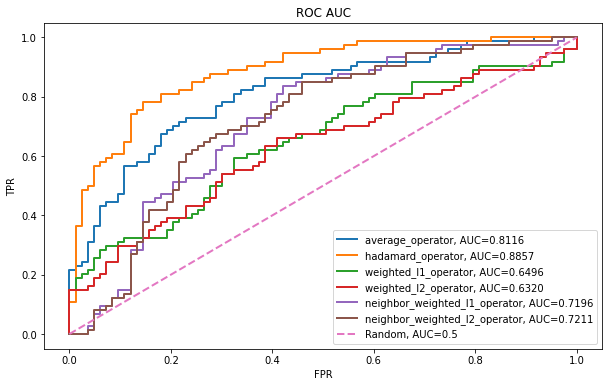

In [30]:
plt.figure(figsize=(10, 6))
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 6. Walklets model (4 points)

In [31]:
!pip install gensim==4.0.0

In [32]:
from gensim.models.word2vec import Word2Vec

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Walklets (Perozzi, Kulkarni & Skiena, 2016) use a weighted combination of embeddings of powers of adjacency matrix $A$, $A^2$, …, $A^k$ to reduce the bias of Deepwalk for low-order proximities, and approximates computing $A^i$ by skipping nodes using short random walks (Perozzi et al., 2017). Walklets captures multiple scales of relationships between vertices in a graph. The method itself is scalable, and can be run on graphs with millions of vertices.

Firstly, we need to sample some random walks. You can take this function from the DeepWalk task of the node classification assignment.

In [33]:
def random_walks(G, n_walks, path_length):
    # YOUR CODE HERE
    walks = []
    for node in G.nodes:
        for _ in range(n_walks):
            current_walk = [node] + [None] * (path_length - 1)
            next_node = np.random.choice([x for x in G.neighbors(node)])
            for j in range(1, path_length):
                current_walk[j] = next_node
                next_node = np.random.choice([x for x in G.neighbors(next_node)])
            walks.append(current_walk)
    return np.array(walks)

In [34]:
walks = random_walks(nx.karate_club_graph(), 10, 5)

assert walks.shape == (34*10, 5)
for i, j in zip(walks[0, :-1], walks[0, 1:]):
    assert nx.karate_club_graph().has_edge(i, j)
assert np.all(walks[:, 0] == np.repeat(np.arange(34), 10))

Similar to DeepWalk, we model the network through a series of truncated random walks started at each node. However, we make a key change to the sampling procedure. Specifically, we choose to skip some of the the nodes in the random walk. In this way, we form a set of relationships which are sampled from successively higher powers of A.

Function `skip_steps` separates a random walk `walk` on the several walks with `n_steps` steps between nodes. It returns list of lists with random walks with skips steps, look at asserts.

In [35]:
def skip_steps(walk, n_steps):
    # YOUR CODE HERE
    return [walk[i::n_steps] for i in range(n_steps+1)]

In [36]:
walk = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
assert skip_steps(walk, 2) == [[0, 2, 4, 6, 8], [1, 3, 5, 7, 9], [2, 4, 6, 8]]
assert skip_steps(walk, 3) == [[0, 3, 6, 9], [1, 4, 7], [2, 5, 8], [3, 6, 9]]

skipped = skip_steps(walks[0], 2)
assert len(skipped) == 3
assert len(skipped[1]) == 2

Next, we prepare walklets as follows: skip steps in each random walk and union them into a single list. Write a function `generate_walklets` that takes input random walks and number of steps, return a dataset with skipped random walks.

In [37]:
def generate_walklets(input_walks, n_steps):
    # YOUR CODE HERE
    return [dataset_walk for walk in input_walks for dataset_walk in skip_steps(walk, n_steps)]

In [38]:
example_walks = [[0, 2, 4, 6, 8], [1, 3, 5, 7, 9], [2, 4, 6, 8]]
assert (
    generate_walklets(example_walks, 2) == 
    [[0, 4, 8], [2, 6], [4, 8], [1, 5, 9], [3, 7], [5, 9], [2, 6], [4, 8], [6]]
)

walklets = generate_walklets(walks, 2)
assert len(walklets) == 1020
assert len(walklets[1]) == 2

To train embedding you need to know the set of nodes, sampled random walks without skips, size of the maximal desired skip (window_size) and dimension of embedding for the one skip.

The function `train_embedding` should work as follows:
For each skip_length between `1` and `window_size + 1`
1. Create dataset with splits
2. Train Word2Vec model on the created walklets with given vector_size, min_count=1, epochs=10 and window=1.
3. Save embeddings for the given step

After all iterations you need to take a mean of received embeddings for a node from each step. Finally, we return np.array with embeddings ordered by the id of node, if node id has no embedding, then use `np.zeros(vector_size)`

In [39]:
def train_embedding(nodes, walks, window_size, vector_size):
    # YOUR CODE HERE
    list_of_emb = []

    for skip_length in range(1, window_size + 1):
        walklets = generate_walklets(walks, skip_length)
        list_of_walks = [[str(node) for node in walk] for walk in walklets]
        model = Word2Vec(list_of_walks,
                        vector_size=vector_size,
                        min_count=1,
                        epochs=10,
                        window=1)
        
        emb = np.empty((len(nodes), vector_size))
        #for node in nodes:
        #    emb[node] = model.wv[str(node)]
        for node in model.wv.index_to_key:
            emb[int(node)] = model.wv[node]
        list_of_emb.append(emb)
    
    return np.array(list_of_emb).mean(axis=0)

In [40]:
np.random.seed(0)
G = nx.Graph(train_edges)
nodes = np.arange(np.max(train_edges) + 1)
walks = random_walks(G, n_walks=5, path_length=10)
emb = train_embedding(nodes, walks, window_size=3, vector_size=8)
assert emb.shape == (1005, 8)

In [41]:
operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(test_pairs) * 0.8)
res = {}
for name, operator in operators.items():
    lr = LogisticRegression()
    edge_emb = operator(G, emb, test_pairs)
    lr.fit(edge_emb[:train_split], y_true[:train_split])
    preds = lr.predict_proba(edge_emb[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[name] = {
        'fpr': fpr,
        'tpr': tpr
    }
assert auc(fpr, tpr) > 0.75

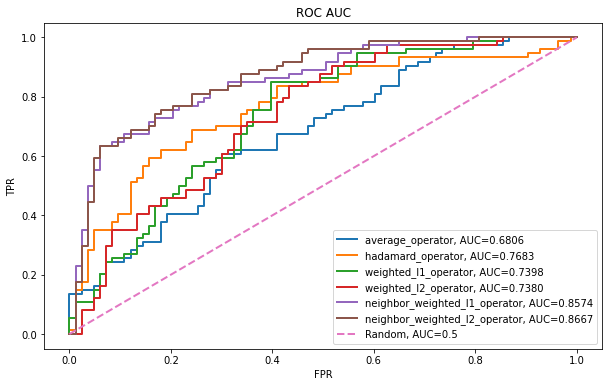

In [42]:
plt.figure(figsize=(10, 6))
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()